In [1]:
from fastai.vision.all import *
import re
import torch

In [2]:
path = untar_data(URLs.PETS)

path.ls()

(#2) [Path('/home/legion/.fastai/data/oxford-iiit-pet/annotations'),Path('/home/legion/.fastai/data/oxford-iiit-pet/images')]

In [3]:
fname = (path/'images').ls()[1]
regex = r'(.+)_\d+.jpg$'
re.findall(regex, fname.name)

['shiba_inu']

In [4]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed = 42),
                 get_y=using_attr(RegexLabeller(regex), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))

dls = pets.dataloaders(path/'images')

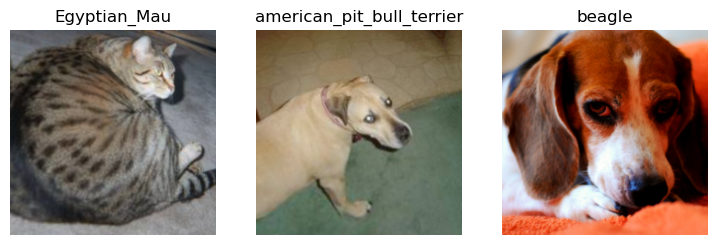

In [5]:
dls.show_batch(nrows=1, ncols=3)

In [6]:
pets.summary(path/'images')

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/legion/.fastai/data/oxford-iiit-pet/images/newfoundland_72.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x375
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/legion/.fastai/data/oxford-iiit-pet/images/newfoundland_72.jpg
    applying partial gives
      newfoundland
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(27)

Final sample: (PILImage mode=RGB size=500x375, TensorCategory(27))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
S

In [7]:
learn = vision_learner(dls, models.resnet34, metrics=[error_rate])
learn.fine_tune(2)

/home/legion/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/legion/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
x,y = dls.one_batch()
preds, _ = learn.get_preds(dl=[(x,y)])
preds[0]
print(f'Length of predictions {len(preds)}, sum of predictions {preds[0].sum()}')

Length of predictions 64, sum of predictions 0.9999998807907104


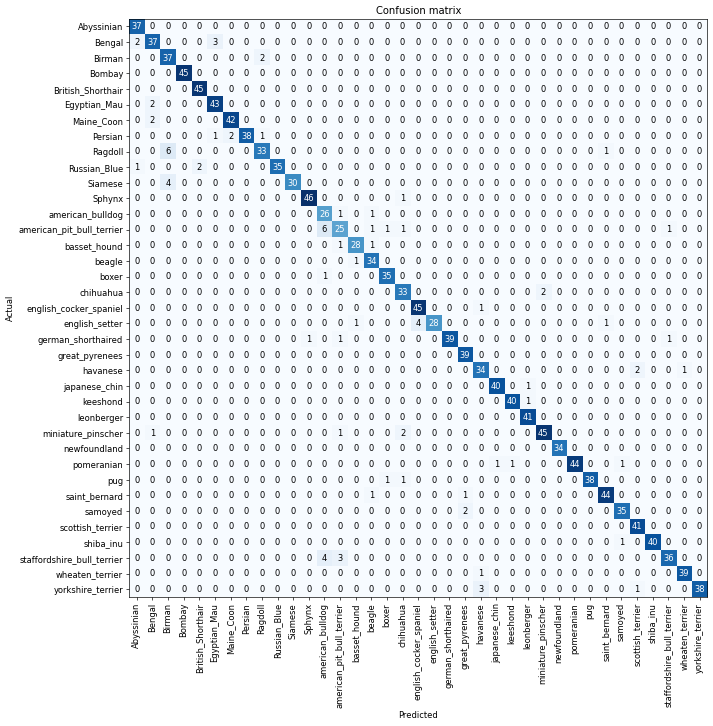

In [9]:
loss = torch.nn.CrossEntropyLoss()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [10]:
interp.most_confused(min_val=5)

[('Ragdoll', 'Birman', 6),
 ('american_pit_bull_terrier', 'american_bulldog', 6)]

In [11]:
learn.fine_tune(1, base_lr=0.1)

Minimum/10: 2.51e-04, steepest point: 2.29e-06


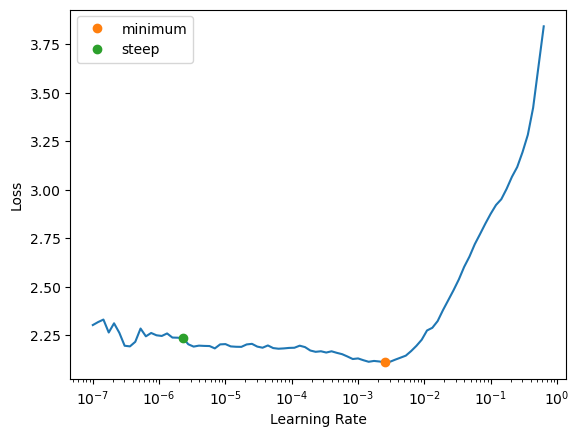

In [12]:
learn2 = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()
learn2.fine_tune(1, base_lr=0.1)
lr_min, lr_steep, = learn2.lr_find(suggest_funcs=(minimum, steep))
print(f'Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}')


In [13]:
learn3 = vision_learner(dls, models.resnet34, metrics=[error_rate])
learn3.fine_tune(2, base_lr=1.45e-06)

In [14]:
learn3.fit_one_cycle(3, 1.45e-06)

In [17]:
learn4 = vision_learner(dls, resnet34, metrics=error_rate)
learn4.fit_one_cycle(3, 3e-3)

/home/legion/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/legion/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Minimum/10: 7.59e-06, steepest point: 3.31e-06


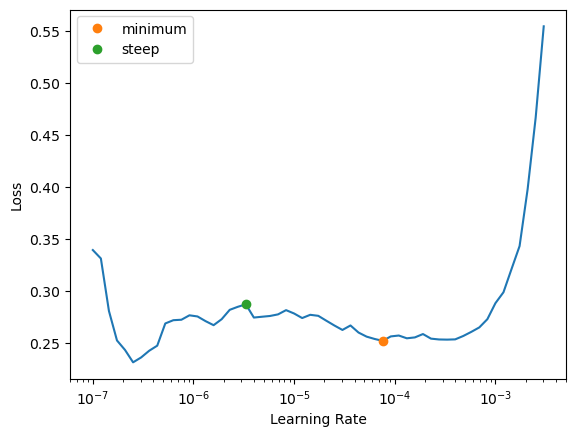

In [18]:
learn4.unfreeze()
lr_min, lr_steep, = learn4.lr_find(suggest_funcs=(minimum, steep))
print(f'Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}')

In [19]:
learn4.fit_one_cycle(6, lr_max=1.0e-4)

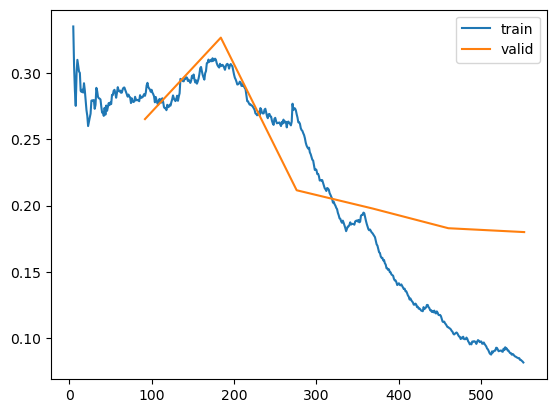

In [20]:
learn4.recorder.plot_loss()

/home/legion/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/legion/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.263973,0.232782,0.078484,00:39
1,0.258975,0.217990,0.072395,00:40
2,0.229954,0.213029,0.069689,00:40
3,0.211017,0.208346,0.065629,00:40
4,0.200343,0.197264,0.060893,00:40
5,0.172788,0.196302,0.061570,00:40
6,0.160802,0.194640,0.062246,00:40
7,0.148749,0.195999,0.062923,00:40
8,0.132529,0.188291,0.062246,00:41
9,0.129445,0.191090,0.060893,00:41


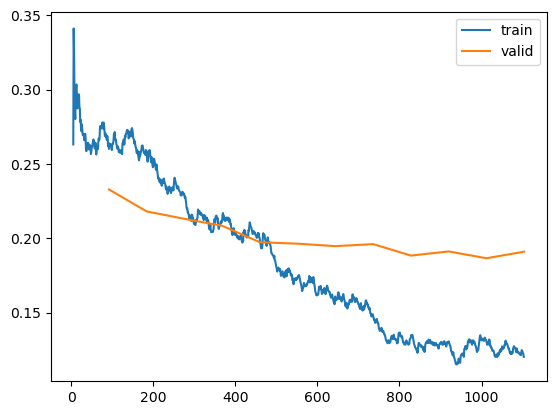

In [21]:
learn5 = vision_learner(dls, resnet34, metrics=error_rate)
learn5.fit_one_cycle(3, 3e-3)
learn5.unfreeze()
learn5.fit_one_cycle(12, lr_max=slice(1e-6, 1e-4))
learn5.recorder.plot_loss()

In [24]:
from fastai.callback.fp16 import *
learn6 = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()
learn6.fine_tune(6, freeze_epochs=3)

OutOfMemoryError: Exception occured in `TrainEvalCallback` when calling event `before_fit`:
	CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 5.79 GiB total capacity; 4.54 GiB already allocated; 3.50 MiB free; 4.57 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF